In [1]:
import time
import os
import torch
import numpy as np
from torch.optim import LBFGS

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from scipy.interpolate import griddata

In [2]:
def fetch_grid_data(domain, dom_grd):
    x_min    = domain[0][0]
    x_max    = domain[1][0]

    t_min    = domain[0][1]
    t_max    = domain[1][1]
    
    x0    = torch.linspace( x_min, x_max, dom_grd[0]+1 ).reshape(-1,1)
    x     = x0.repeat(dom_grd[1]+1,1).reshape(-1,1)
    t0    = torch.linspace( t_min, t_max, dom_grd[1]+1 ).reshape(-1,1)
    t     = t0.repeat(1,dom_grd[0]+1).reshape(-1,1)
    return x,t

In [3]:
def u_exact(x,t):
    return torch.sin(pi*x)*torch.cos(2*pi*t) + torch.sin(4*pi*x)*torch.cos(8*pi*t)/2 

def discretized_physics_loss(u, x, y, domain, dom_grd):
    deltax = (domain[1][0] - domain[0][0]) / (dom_grd[0]+1)
    deltat = (domain[1][1] - domain[0][1]) / (dom_grd[1]+1)
    u_mat = u.reshape(dom_grd[1]+1, dom_grd[0]+1)

    u_xx   = ( u_mat[1:-1,2:] - 2*u_mat[1:-1,1:-1] + u_mat[1:-1,:-2] ) / deltax**2
    u_tt   = ( u_mat[2:,1:-1] - 2*u_mat[1:-1,1:-1] + u_mat[:-2,1:-1] ) / deltat**2

    loss = (u_tt - 4*u_xx).reshape(-1,1).pow(2)
    return loss

def discretized_boundary_loss(u, dom_grd):
    u_mat = u.reshape(dom_grd[1]+1, dom_grd[0]+1)
    u_bc  = torch.cat((u_mat[:,0], u_mat[:,-1])).reshape(-1,1)
    loss  = (u_bc - 0.).pow(2)
    return loss

def discretized_initial_loss(u, x, t, dom_grd):
    u_mat = u.reshape(dom_grd[1]+1, dom_grd[0]+1)
    u_ic  = u_mat[0,:].reshape(-1,1)
    
    x_ic = x.reshape(dom_grd[1]+1, dom_grd[0]+1)[0,:].reshape(-1,1)
    t_ic = t.reshape(dom_grd[1]+1, dom_grd[0]+1)[0,:].reshape(-1,1)
    u_e  = u_exact(x_ic,t_ic)
    loss = (u_ic - u_e).pow(2)
    return loss

def evaluate(u, x, y):
    u_star = u_exact(x, y)

    l2   = np.linalg.norm(u_star- u.detach(), 2)/np.linalg.norm(u_star, 2)
    linf = max(abs(u_star- u.detach().numpy())).item()
    return l2,linf

In [4]:
methodname = 'odil_alm'

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi)

domain = np.array([[0., 0.],
                   [1., 1.]])

epochs = 500
disp   = 10
print_to_consol = True

trials = 5

linf_norms = []
l2_norms = []
for trial in range(1, trials+1):
    print("*"*20 + f' run({trial}) '+"*"*20)
    
    dom_grd = [25, 25]
    samplename = "dom_grd"+str(dom_grd[0])+"_"+str(dom_grd[1])

    x_dm, t_dm = fetch_grid_data(domain, dom_grd)

    # initialize optimizer parameters u
    b = torch.tensor(np.sqrt( 6/x_dm.shape[0]))
    u_dm = (-b - b) * torch.rand(x_dm.shape) + b
    u_dm = u_dm.requires_grad_(True)
    
    opt_lbfgs = LBFGS([u_dm], line_search_fn="strong_wolfe")
    
    # initialize lambda and mu
    num_lambda = 2
    Mu = torch.ones(num_lambda, 1)
    Lambda = torch.zeros(num_lambda, 1)
    
    epsilon = torch.tensor(1e-8)
    mu_max  = torch.tensor(1e+4)
    eta     = torch.tensor(0.0)
    
    for epoch in range(1, epochs+1):        
        def _closure():
            pde_loss = discretized_physics_loss(u_dm, x_dm, t_dm, domain, dom_grd)
            avg_pde_loss = torch.mean(pde_loss)
            
            bc_loss = discretized_boundary_loss(u_dm, dom_grd)
            ic_loss = discretized_initial_loss(u_dm, x_dm, t_dm, dom_grd)
            avg_bc_loss = torch.mean(bc_loss).reshape(1, 1)
            avg_ic_loss = torch.mean(ic_loss).reshape(1, 1)
            
            constr = torch.cat((avg_ic_loss, avg_bc_loss), 0)
            penalty = constr.pow(2).sum()
            loss = avg_pde_loss + (Lambda * constr).sum() + 0.5 * (Mu * constr.pow(2)).sum()
            return avg_pde_loss, constr, penalty, loss
        
        def closure():
            if torch.is_grad_enabled():
                opt_lbfgs.zero_grad()
            avg_pde_loss, constr, penalty, loss = _closure()
            if loss.requires_grad:
                  loss.backward()
            return loss
        
        opt_lbfgs.step(closure)
        avg_pde_loss, constr, penalty, loss = _closure()
        
        with torch.no_grad():
            if (torch.sqrt(penalty) >= 0.25*eta) and (torch.sqrt(penalty) > epsilon):
                Mu = 2*Mu
                Mu[Mu >mu_max] = mu_max
                Lambda += Mu * constr
            eta = torch.sqrt(penalty)

        if epoch % disp == 1 and print_to_consol:
            print(f"epoch : {epoch:3d}, avg pde res :{avg_pde_loss.detach().item():2.3e}")

    torch.save({'x': x_dm, 't': t_dm, 'u': u_dm.detach(),
                'nx': torch.tensor(dom_grd[0]+1), 'nt': torch.tensor(dom_grd[1]+1)},
               f'{trial}_data_physics.pth')
    l2, linf = evaluate(u_dm, x_dm, t_dm)
    l2_norms.append(l2)
    linf_norms.append(linf)
    print(f"relative l2 error :{l2:2.3e}, linf error : {linf:2.3e}")

******************** run(1) ********************
epoch :   1, avg pde res :5.532e+01
epoch :  11, avg pde res :5.162e+01
epoch :  21, avg pde res :3.500e+01
epoch :  31, avg pde res :2.158e+01
epoch :  41, avg pde res :4.831e+00
epoch :  51, avg pde res :1.704e+00
epoch :  61, avg pde res :2.716e-01
epoch :  71, avg pde res :2.979e-02
epoch :  81, avg pde res :1.517e-02
epoch :  91, avg pde res :3.443e-03
epoch : 101, avg pde res :1.127e-03
epoch : 111, avg pde res :5.080e-04
epoch : 121, avg pde res :1.164e-04
epoch : 131, avg pde res :2.860e-05
epoch : 141, avg pde res :1.083e-05
epoch : 151, avg pde res :3.203e-06
epoch : 161, avg pde res :7.033e-07
epoch : 171, avg pde res :2.658e-07
epoch : 181, avg pde res :1.898e-07
epoch : 191, avg pde res :8.703e-08
epoch : 201, avg pde res :8.703e-08
epoch : 211, avg pde res :8.703e-08
epoch : 221, avg pde res :8.703e-08
epoch : 231, avg pde res :8.703e-08
epoch : 241, avg pde res :8.703e-08
epoch : 251, avg pde res :8.703e-08
epoch : 261, av

In [5]:
print('mean L_2: %2.3e' % np.mean(l2_norms))
print('std  L_2: %2.3e' % np.std(l2_norms))
print('*'*20)
print('mean L_inf: %2.3e' % np.mean(linf_norms))
print('std  L_inf: %2.3e' % np.std(linf_norms))
print("*"*20)
print('total trials: ', trials)

trial2 = np.array([l2_norms.index(max(l2_norms)),
                  l2_norms.index(min(l2_norms))]) + 1
print('worst trial: ', trial2[0])
print(
    f"relative l2 error :{l2_norms[trial2[0]-1]:2.3e}, linf error : {linf_norms[trial2[0]-1] :2.3e}")
print('best trial: ', trial2[1])
print(
    f"relative l2 error :{l2_norms[trial2[1]-1]:2.3e}, linf error : {linf_norms[trial2[1]-1] :2.3e}")

mean L_2: 2.291e-01
std  L_2: 1.703e-03
********************
mean L_inf: 4.184e-01
std  L_inf: 4.655e-03
********************
total trials:  5
worst trial:  3
relative l2 error :2.319e-01, linf error : 4.189e-01
best trial:  4
relative l2 error :2.266e-01, linf error : 4.141e-01


In [6]:
# https://joseph-long.com/writing/colorbars/
def colorbar(mappable,min_val,max_val):
    from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    return cbar

params = {
    'text.latex.preamble': '\\usepackage{gensymb}',
    'image.origin': 'lower',
    'image.interpolation': 'nearest',
    'image.cmap': 'gray',
    'axes.grid': False,
    'savefig.dpi': 150,  # to adjust notebook inline plot size
    'axes.labelsize': 16, # fontsize for x and y labels
    'axes.titlesize': 16,
    'font.size': 16, 
    'legend.fontsize': 16, 
    'xtick.labelsize': 16,
    'ytick.labelsize': 16,
    'text.usetex': False,
    'figure.figsize': [20, 3],
    'font.family': 'serif',
}
plt.rcParams.update(params)


def contour_sol(domain, methodname, samplename, trial):
    data = torch.load(f'Data/{trial}_data_physics.pth')
    x = data['x']
    t = data['t']
    u = data['u']
    nx = data['nx']
    nt = data['nt']

    u_star = u_exact(x,t)
    x_star = x.reshape(nt, nx)
    t_star = t.reshape(nt, nx)

    # ------------
    # 2D figures
    # --------------
    cmap_list = ['jet','YlGnBu','coolwarm','rainbow','magma','plasma','inferno','Spectral','RdBu']
    cmap = cmap_list[3]
    gs = gridspec.GridSpec(1, 3)
    gs.update(wspace=0.3)

    points      = np.concatenate((x, t),axis=1)
    u_pred_plot = griddata(points, u.flatten(), (x_star,t_star), method='cubic')
    u_star_plot = griddata(points, u_star.flatten(), (x_star,t_star), method='cubic')

    #save = True
    #################################### Exact Solution #####################################
    ax = plt.subplot(gs[0,0])
    min_val = np.min(u_star_plot)
    max_val = np.amax(u_star_plot)
    img = ax.pcolormesh(x_star,t_star,u_star_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
    ax.set_title('$\hat{u}(x,t)$')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    cbar = colorbar(img,min_val,max_val)
    cbar.formatter.set_powerlimits((0, 0))
    ax.axis('square')
    ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
    ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])


    #################################### Predicted Solution #########################################
    ax = plt.subplot(gs[0,1])
    img = ax.pcolormesh(x_star,t_star,u_pred_plot, cmap = cmap,vmin=min_val,vmax=max_val,shading='gouraud')
    ax.set_title('$u(x,y)$')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')
    cbar = colorbar(img,min_val,max_val)
    cbar.formatter.set_powerlimits((0, 0))
    ax.axis('square')
    ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
    ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])


    #################################### Absolute Error #########################################
    ax = plt.subplot(gs[0,2])
    min_val = np.amin(np.abs(u_star_plot - u_pred_plot))
    max_val = np.amax(np.abs(u_star_plot - u_pred_plot))
    img = ax.pcolormesh(x_star,t_star,np.abs(u_star_plot - u_pred_plot), norm=colors.LogNorm(vmin=1.e-3, vmax=1.e+0), cmap = cmap,shading='gouraud')
    ax.set_title('$|u - \hat{u}|$')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$t$')

    cbar = colorbar(img,min_val,max_val)
    ax.axis('square')
    ax.set_xticks([domain[0][0],(domain[1][0]+ domain[0][0])/2,domain[1][0]])
    ax.set_yticks([domain[0][1],(domain[1][1]+domain[0][1])/2,domain[1][1]])
    
    plt.figtext(0.229, -0.25,'(a)' ,wrap=True, horizontalalignment='center',fontsize=20)
    plt.figtext(0.508, -0.25,'(b)', wrap=True, horizontalalignment='center', fontsize=20)
    plt.figtext(0.790, -0.25,'(c)', wrap=True, horizontalalignment='center', fontsize=20)
    plt.savefig('{}_{}_{}.png'.format(methodname, samplename, trial), bbox_inches='tight', pad_inches=0.02)
    plt.show()

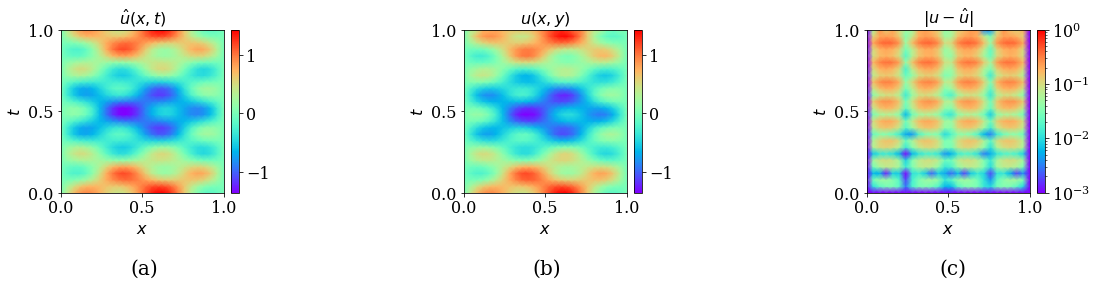

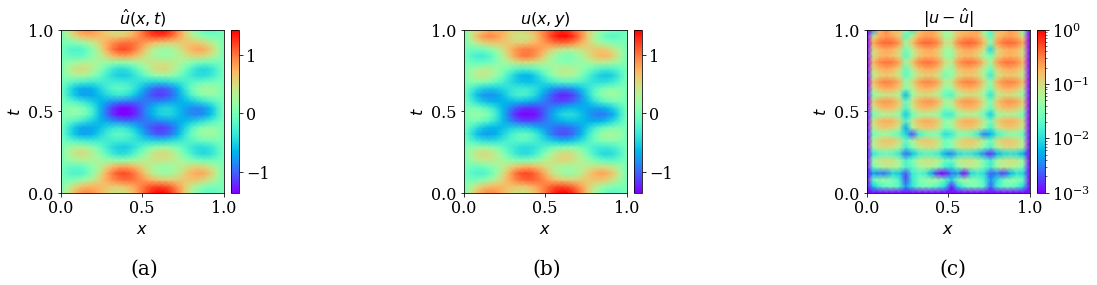

In [7]:
for trial in trial2:
    contour_sol(domain, methodname, samplename, trial)